# 使用3d-UNet做海马区分割的探索

**训练中遇到的问题和解决方案**：

* 显存不够 ： resize成64x64，batchsize调整为1，去除一次降采样和逆卷积操作
* 损失显示Nan : 去除Normalize后的NAN值


## 1 获取本机的GPU
torch.device

In [1]:
'''
获取GPU，以后通过如下方式将模型和数据送入GPU:
# net.to(device)
# input,labels = data[0].to(device), data[1].to(device)
'''

import torch 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)


cuda:0


'\n# net.to(device)\n# input,labels = data[0].to(device), data[1].to(device)\n'

## 2 数据的预处理

def normalization(data): 标准化

def cat_image(direc)   : 拼接2d图为3d

def cat_mask(direc)    : 拼接2d mask为3d后拼接左右侧海马区

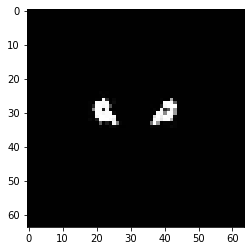

In [2]:
import cv2 as cv
import numpy as np 
import os 
import matplotlib.pyplot as plt 

'''

2d longitudinal slice的标准化 常用的numpy标准化函数

'''
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range


'''
cat_image : 拼接189张longitudinal的png图片为一个4维的Numpy数组：C X D X H X W
            标准化后消除nan数据

'''
def cat_image(direc):
    ret_img = np.empty((1,189,64,64),dtype=np.float32)
    paths = os.listdir(direc)
    for i,imgs in enumerate(paths):
        img = cv.imread(os.path.join(direc,imgs),0)
        img = cv.resize(img,(64,64)).astype(np.float32)
        img = normalization(img)
        whereNan = np.isnan(img)
        img[whereNan] = 0
        ret_img[0][i] = img 
        
    return ret_img


'''
cat_mask : 分别拼接左右侧海马区的mask为一个4维数组后再把两个海马区的mask合为一个数组作为label
            标准化后消除nan数据

'''
def cat_mask(direc):

    name = direc.split('\\')
    leftmaskdir = name[-1][:-4] + 'L'
    rightmaskdir = name[-1][:-4] + 'R'
    leftfiles = os.listdir(os.path.join(direc,leftmaskdir))
    rightfiles = os.listdir(os.path.join(direc,rightmaskdir)) 
    imgret = np.empty((1,189,64,64),dtype=np.float32)
    for i,(lf,rf) in enumerate(zip(leftfiles,rightfiles)):

        imgl = cv.imread(os.path.join(direc,leftmaskdir,lf),0)
        imgl = cv.resize(imgl,(64,64)).astype(np.float32)
        imgl = normalization(imgl)
        whereNan = np.isnan(imgl)
        imgl[whereNan] = 0

        imgr = cv.imread(os.path.join(direc,rightmaskdir,rf),0)
        imgr = cv.resize(imgr,(64,64)).astype(np.float32)
        imgr = normalization(imgr)
        whereNan = np.isnan(imgr)
        imgr[whereNan] = 0

        img_cat = imgl+imgr 
        where_larger_than_1 = img_cat > 1
        img_cat[where_larger_than_1] = 1 
        imgret[0][i] = img_cat
    return imgret 
p1 = cat_mask('.\\DB3\\label\\100label\\ADNI_002_S_0295_13722_ACPC')
plt.imshow(p1[0,73,:,:],cmap='gray') 

## 3 制作数据集
class MRI_Train(Dataset) ： 继承pytorch的Dataset，制作训练数据集,把所有训练样本转为Tensor存入RAM

class MRI_Test(Dataset) ： 继承pytorch的Dataset，制作测试数据集，把所有测试样本转为Tensor存入RAM

In [3]:
from torch.utils.data import Dataset,DataLoader
import os 
import torchvision
import torch 
class MRI_Train(Dataset):

    def __init__(self):

        self.imgs = []
        self.masks = []
        imgdir = 'E:\\IMAGE PROCESSING\\DB3\\original\\'
        imgtraindir = '100'
        labdir = 'E:\\IMAGE PROCESSING\\DB3\\label\\'
        labtraindir = '100label'
        #　create dataset
        img_individuals = os.listdir(os.path.join(imgdir,imgtraindir))
        label_individuals = os.listdir(os.path.join(labdir,labtraindir))
        for dirs in img_individuals:
            pi = cat_image(os.path.join(imgdir,imgtraindir,dirs))
            self.imgs.append(torch.from_numpy(pi)) 
        for dirs in label_individuals:
            mi = cat_mask(os.path.join(labdir,labtraindir,dirs))
            self.masks.append(torch.from_numpy(mi))

    def __getitem__(self,index):
        return (self.imgs[index],self.masks[index])

    def __len__(self):
        return len(self.imgs)



class MRI_Test(Dataset):
    def __init__(self):
        self.imgs = []
        self.masks= []
        imgdir = 'E:\\IMAGE PROCESSING\\DB3\\original\\'
        imgtestdir = '35'
        labdir = 'E:\\IMAGE PROCESSING\\DB3\\label\\'
        labtestdir ='35label'
        # create dataset 
        img_individuals = os.listdir(os.path.join(imgdir,imgtestdir))
        label_individuals = os.listdir(os.path.join(labdir,labtestdir))
        for dirs in img_individuals:
            pi = cat_image(os.path.join(imgdir,imgtestdir,dirs))
            self.imgs.append(torch.from_numpy(pi)) 
        for dirs in label_individuals:
            mi = cat_mask(os.path.join(labdir,labtestdir,dirs))
            self.masks.append(torch.from_numpy(mi)) 
        
    def __getitem__(self,index):
        return (self.imgs[index],self.masks[index])

    def __len__(self):
        return len(self.imgs)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

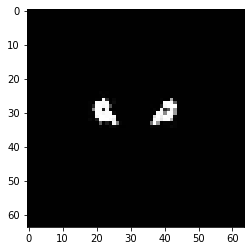

In [4]:
trainset = MRI_Train()
testd = trainset[0][1]
print(testd)
plt.imshow(trainset[0][1][0][73],cmap='gray') 


In [5]:
testset = MRI_Test()

## 4 创建DataLoader，便于做batch训练

DL\['train'\]为训练集的DataLoader

DL\['val'\]为验证集的DataLoader

In [6]:
DS = {'train':trainset,'val':testset}
DL = {'train':DataLoader(DS['train'], batch_size = 1, shuffle = True, num_workers = 0),'val':DataLoader(DS['val'], batch_size = 1, shuffle = True, num_workers = 0)}

## 5 定义3d-UNet



In [4]:
import torch.nn as nn 
import torch.nn.functional as F
'''

unet parts

'''

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose3d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CDHW
        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2,
                        diffZ // 2, diffZ - diffZ // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

'''

unet 

'''
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        #x5 = self.down4(x4)
        x = self.up2(x4, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.outc(x)
        return logits

In [8]:
myunet = UNet(1,1,False)

## 6 定义训练函数，实例化模型、损失函数、优化器

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in DL[phase]:
                #inputs = inputs.double()
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #print('output suc')
                    #_, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                del loss 
                #running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} '.format(
                phase, epoch_loss))
            torch.cuda.empty_cache()
            torch.save(model.state_dict(),os.path.join('E:\\Image Processing','params_7_4.pkl'))
            # deep copy the model
            '''
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            '''
        torch.save(model.state_dict(),os.path.join('E:\\Image Processing','params_7_4.pkl'))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    #model.load_state_dict(best_model_wts)
    return model

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


#myunet = myunet.double()
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
myunet = myunet.to(device)

#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(myunet.parameters(), lr=0.001, momentum=0.9)
#optimizer_ft = optim.RMSprop(myunet.parameters(), lr=0.1, weight_decay=1e-8, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## 7 开始训练

In [11]:
import time
import copy

dataset_sizes = {x: len(DS[x]) for x in ['train', 'val']}
myunet = train_model(myunet, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.2852 
val Loss: 0.0974 

Epoch 1/4
----------
train Loss: 0.0673 
val Loss: 0.0487 

Epoch 2/4
----------
train Loss: 0.0417 
val Loss: 0.0358 

Epoch 3/4
----------
train Loss: 0.0323 
val Loss: 0.0296 

Epoch 4/4
----------
train Loss: 0.0276 
val Loss: 0.0260 

Training complete in 19m 4s


In [14]:
def train_model_withParam(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    torch.load()
    #best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    model.load_state_dict(torch.load('E:\\Image Processing\\params_7_4.pkl'))
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in DL[phase]:
                #inputs = inputs.double()
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #print('output suc')
                    #_, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                del loss 
                #running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} '.format(
                phase, epoch_loss))
            torch.cuda.empty_cache()
            torch.save(model.state_dict(),os.path.join('E:\\Image Processing','params_7_3_1227.pkl'))
            # deep copy the model
            '''
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            '''
        torch.save(model.state_dict(),os.path.join('E:\\Image Processing','params_7_3_1227.pkl'))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    #model.load_state_dict(best_model_wts)
    return model

In [15]:
import time
import copy

dataset_sizes = {x: len(DS[x]) for x in ['train', 'val']}
myunet = train_model(myunet, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0247 
val Loss: 0.0238 

Epoch 1/9
----------
train Loss: 0.0229 
val Loss: 0.0223 

Epoch 2/9
----------
train Loss: 0.0221 
val Loss: 0.0222 

Epoch 3/9
----------
train Loss: 0.0220 
val Loss: 0.0221 

Epoch 4/9
----------
train Loss: 0.0219 
val Loss: 0.0221 

Epoch 5/9
----------
train Loss: 0.0218 
val Loss: 0.0219 

Epoch 6/9
----------
train Loss: 0.0216 
val Loss: 0.0218 

Epoch 7/9
----------
train Loss: 0.0215 
val Loss: 0.0217 

Epoch 8/9
----------
train Loss: 0.0214 
val Loss: 0.0216 

Epoch 9/9
----------
train Loss: 0.0214 
val Loss: 0.0215 

Training complete in 39m 41s


## 8 验证训练结果

In [5]:
import matplotlib.pyplot as plt 
def pred(model,sample):
    ori = sample[0]
    print(type(ori))
    ori = ori.reshape((1,ori.size()[0],ori.size()[1],ori.size()[2],ori.size()[3]))
    tar = sample[1][0]
    ori = ori.to(device)
    outputs = model(ori)
    outputs = outputs.to('cpu')
    outputs = outputs.detach().numpy() 
    predimg = outputs[0][0] 
    oriimg = sample[0].numpy()[0]
    return oriiimg,tar,predimg

    
    


In [6]:
m1 = cat_mask('.\\DB3\\label\\100label\\ADNI_002_S_0295_13722_ACPC')
p1 = torch.from_numpy(cat_image('.\\DB3\\original\\100\\ADNI_002_S_0295_13722_ACPC'))

<class 'torch.Tensor'>


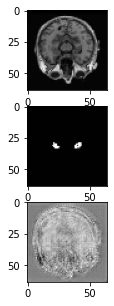

In [7]:
unet = UNet(1,1,False)
unet = unet.to(device)
unet.load_state_dict(torch.load('E:\\Image Processing\\params_7_3_1227.pkl'))
oriimg,tar,predimg = pred(unet,(p1,m1))


plt.figure(None,(5,5))
plt.subplot(3,1,1)
plt.imshow(oriimg[70,:,:],cmap='gray')
plt.subplot(312)
plt.imshow(tar[70,:,:],cmap='gray')
plt.subplot(313)
plt.imshow(predimg[70,:,:],cmap='gray')